In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_error

# Carregar dados do CPU
machine = 'm_694.csv'
workload = pd.read_csv(machine, 
             names = ['machine_id', 'time_stamp', 'cpu', 'mem', 'mem_gps', 
                      'mkpi', 'net_in', 'net_out', 'disk_io_percent'])
workload.time_stamp = pd.to_datetime(workload.time_stamp, unit='s')
workload.set_index('time_stamp', inplace=True)
workload = workload.resample('5min').interpolate()
workload = workload[-12*24*3:] # 5min * 12 * 24 * 3 = 3 days
workload


,machine_id,cpu,mem,mem_gps,mkpi,net_in,net_out,disk_io_percent
time_stamp,,,,,,,,
1970-01-06 00:00:00,m_694,25.0,96.0,NaN,NaN,46.14,39.77,5.0
1970-01-06 00:05:00,m_694,31.0,97.0,NaN,NaN,46.15,39.78,5.0
1970-01-06 00:10:00,m_694,34.0,94.0,NaN,NaN,46.15,39.78,8.0
1970-01-06 00:15:00,m_694,31.0,92.0,NaN,NaN,46.16,39.79,4.0
1970-01-06 00:20:00,m_694,32.0,94.0,NaN,NaN,46.16,39.79,4.0
...,...,...,...,...,...,...,...,...
1970-01-08 23:35:00,m_694,86.0,91.0,0.35,0.0,51.46,44.74,4.0
1970-01-08 23:40:00,m_694,86.0,92.0,0.27,0.0,51.46,44.75,6.0
1970-01-08 23:45:00,m_694,85.0,92.0,0.45,0.0,51.46,44.75,6.0


In [2]:
data = workload[['cpu']]

# split train and test
n_test = 12*24
test = data[-n_test:]
test

,cpu
time_stamp,
1970-01-08 00:00:00,34.0
1970-01-08 00:05:00,36.5
1970-01-08 00:10:00,39.0
1970-01-08 00:15:00,47.0
1970-01-08 00:20:00,36.0
...,...
1970-01-08 23:35:00,86.0
1970-01-08 23:40:00,86.0
1970-01-08 23:45:00,85.0


In [3]:
# predict naive
predict = test.cpu.shift(1)
test['predict'] = predict
test.dropna(inplace=True)
test

,cpu,predict
time_stamp,,
1970-01-08 00:05:00,36.5,34.0
1970-01-08 00:10:00,39.0,36.5
1970-01-08 00:15:00,47.0,39.0
1970-01-08 00:20:00,36.0,47.0
1970-01-08 00:25:00,39.0,36.0
...,...,...
1970-01-08 23:35:00,86.0,79.0
1970-01-08 23:40:00,86.0,86.0
1970-01-08 23:45:00,85.0,86.0


<AxesSubplot:xlabel='time_stamp'>

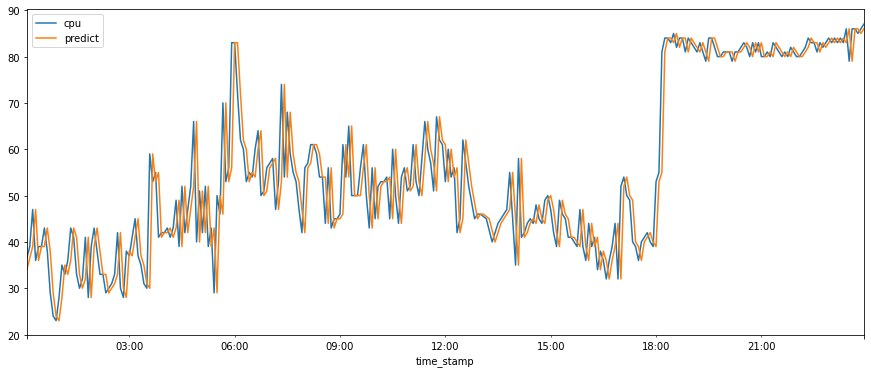

In [4]:
test.plot(figsize=(15,6))

In [5]:
# validate predict with test set
def validate(y_test, pred):
    mse = mean_squared_error(y_test, pred)
    print(f'mean_squared_error: {mse}')
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f'root_mean_squared_error: {rmse}')
    cd = r2_score(y_test, pred)
    print(f'Determination coeficient: {cd}')
    ev = explained_variance_score(y_test, pred)
    print(f'explained_variance_score: {ev}')
    me = max_error(y_test, pred)
    print(f'max_error: {me}')
    mae = mean_absolute_error(y_test, pred)
    print(f'mean_absolute_error: {mae}')

validate(test['cpu'], test['predict'])

mean_squared_error: 55.34146341463415
root_mean_squared_error: 7.439184324550249
Determination coeficient: 0.8225470899709826
explained_variance_score: 0.822656440385144
max_error: 29.0
mean_absolute_error: 5.055749128919861
